In [14]:
""" Load Relevant Packages """ 

import sys
sys.path.insert(0,'/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning')

"""
Python packages
"""

import numpy as np
import seaborn as sns
from scipy import stats, optimize
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
from typing import Union
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import numpy.ma as ma
import math


import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from dateutil.relativedelta import relativedelta


In [206]:
"""
Download data created in Pyhton
"""

# create a numpy array
nparray = most_div_port_weights_monthly_epo

# Saving the array
np.savetxt("most_div_port_weights_monthly_epo.csv", nparray, delimiter=",")

# Reading the csv into an array
firstarray = np.genfromtxt("most_div_port_weights_monthly_epo.csv", delimiter=",")

In [292]:
"""
Load Data
"""
ret = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data.xlsx')
returns = ret.set_index('date')

ret_1 = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data 1.xlsx')
returns_1 = ret_1.set_index('date')

ret_2 = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data 2.xlsx')
returns_2 = ret_2.set_index('date')

ret_3 = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data 3.xlsx')
returns_3 = ret_3.set_index('date')

ret_4 = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/Final data 4.xlsx')
returns_4 = ret_4.set_index('date')

# calculate start and end dates from index
start_date_1 = returns_1.index.min()
end_date_1 = returns_1.index.max()

start_date_2 = returns_2.index.min()
end_date_2 = returns_2.index.max()

start_date_3 = returns_3.index.min()
end_date_3 = returns_3.index.max()

start_date_4 = returns_4.index.min()
end_date_4 = returns_4.index.max()

In [98]:
# colors for factors

cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, len(returns.columns)))

# Define inputs for calculations

In [227]:
"""
Define inputs
"""

# number of periods
num_periods = len(ret)
num_periods_1 = len(ret_1)
num_periods_2 = len(ret_2)
num_periods_3 = len(ret_3)
num_periods_4 = len(ret_4)

# number of factors
num_assets = len(returns.columns)
num_assets_1 = len(returns_1.columns)
num_assets_2 = len(returns_2.columns)
num_assets_3 = len(returns_3.columns)
num_assets_4 = len(returns_4.columns)

# window size 
window_size = 252 # 1 year of daily observations 

# effective number of periods
eff_num_periods = num_periods - window_size
eff_num_periods_1 = num_periods_1 - window_size
eff_num_periods_2 = num_periods_2 - window_size
eff_num_periods_3 = num_periods_3 - window_size
eff_num_periods_4 = num_periods_4 - window_size

# half-life
half_life = window_size/2

# time points
time_points = np.arange(1, window_size + 1)

# equally weighted portfolio
w_eq = np.repeat(1.0 / num_assets, num_assets)
w_eq_1 = np.repeat(1.0 / num_assets_1, num_assets_1)
w_eq_2 = np.repeat(1.0 / num_assets_2, num_assets_2)
w_eq_3 = np.repeat(1.0 / num_assets_3, num_assets_3)
w_eq_4 = np.repeat(1.0 / num_assets_4, num_assets_4)

weights_eq = np.array(w_eq).astype(float)


# Estimate Covariance Matrix

In [66]:
"""
Simple Covariance Matrix
"""

def calculate_simple_cov_mat(x: np.ndarray, axis: int = 0) -> np.ndarray:
    
    x = x.T if axis == 1 else x
    
    cov_mat = np.cov(x, rowvar=False)
    
    return cov_mat

In [67]:
"""
Exponential Decaying Covariance Matrix
"""

# exponential probabilities for decaying covariance matrix
def calculate_exponential_decay_probabilities(target_time_point: Union[int, float], time_points: np.ndarray,
                                              half_life: Union[float, int]) -> np.ndarray:
    """
    Calculates exponential decay probabilities for an array of time points based on a target time point and a half life.
    Parameters
    ----------
    target_time_point:
        The target time point.
    time points:
        The array of time points to calculate probabilities for.
    half_life:
        The half life of the exponential decay.
    Returns
    -------
    Exponential decay probabilities.
    """
    
    numerator = np.exp(-np.log(2) / half_life * np.clip(target_time_point - time_points, 0, np.inf))
    denominator = np.sum(numerator)

    p_t = numerator / denominator

    return p_t

exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# Define function for decaying covariance matrix
def calculate_decaying_cov_mat(x: np.ndarray, probs: np.ndarray, axis: int = 0) -> np.ndarray:

    """
    Estimates a covariance matrix based on a historical dataset and a set of probabilities.
    Parameters
    ----------
    x:
        The dataset to estimate covariance for.
    probs:
        The probabilities to weight the observations of the dataset by.
    axis:
        The axis to estimate over.
    Returns
    -------
    np.ndarray
        The estimated covariance matrix.
    """

    x = x.T if axis == 1 else x

    expected_x_squared = np.sum(probs[:, None, None] * np.einsum('ji, jk -> jik', x, x), axis=0)
    mu = probs @ x
    mu_squared = np.einsum('j, i -> ji', mu, mu)
    cov_mat = expected_x_squared - mu_squared

    return cov_mat

In [68]:
"""
Ledoit and Wold Covariance Shrinkage
"""

def ledoit_wolf_constant_variance(data: np.ndarray, demean: bool = True) -> np.ndarray:
    """
    Computes the Ledoit and Wolf (2004) shrinkage covariance matrix
    See https://www.sciencedirect.com/science/article/pii/S0047259X03000964
    Parameters
    ----------
    data:
        Num. observations x Num. variables
    demean:
        Boolean indicating whether to demean data.
    Returns
    -------
    np.ndarray
        Covariance matrix
    """

    if demean:
        data = data - np.mean(data, axis=0)[None, :]

    T = data.shape[0]

    # calculate sample covariance matrix
    S = data.T @ data / T  # np.cov(data, rowvar=False)

    # get dimension
    N = S.shape[0]

    # calculate constant variance
    m = np.trace(S) / N

    # shrinkage target
    shrink_target = m * np.eye(N)

    # delta
    d2 = np.linalg.norm(S - shrink_target, ord='fro') ** 2 / N

    # beta
    b2_bar = np.sum([np.linalg.norm(np.outer(data[t, :], data[t, :]) - S, ord='fro') ** 2 / N
                     for t in range(T)]) / (T ** 2)

    b2 = np.min([d2, b2_bar])

    # alpha
    a2 = d2 - b2

    # calculate new covariance matrix
    shrinkage_cov_mat = (b2 / d2) * shrink_target + (a2 / d2) * S

    return shrinkage_cov_mat

In [149]:
"""
Simple EPO 
"""

def shrunk_cov_mat(returns: np.ndarray, shrinkage_param: float = 0.50) -> np.ndarray:
    returns_df = pd.DataFrame(returns)
    corr_matrix = returns_df.corr()
    vol_vec = np.sqrt(np.diag(returns_df.cov()))
    shrinked_corr = corr_matrix * (1 - shrinkage_param) + np.identity(len(corr_matrix)) * shrinkage_param
    return np.outer(vol_vec, vol_vec) * shrinked_corr

# Calculate Risk Contributions for Equally Weighted Portfolio

In [70]:
def calculate_marginal_risks_std(weights: np.ndarray, cov_mat: np.ndarray) -> np.ndarray:
    """
    Function that calculates marginal risk using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    total_risk = np.sqrt(weights @ cov_mat @ weights)
    inner_derivative = cov_mat @ weights

    return inner_derivative / total_risk


def calculate_risk_contributions_std(weights: np.ndarray, cov_mat: np.ndarray, scale: bool = False) -> np.ndarray:
    """
    Function that calculates risk contributions using std. as portfolio risk measure
    Parameters
    ----------
    weights:
        Portfolio weights
    cov_mat:
        Covariance matrix
    scale:
        Scale risk contribution.
    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_std(weights, cov_mat)
    mrc = weights * mr

    if scale:
        mrc /= np.sum(mrc)

    return mrc

In [71]:
rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_simple_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

In [49]:
"""
Perform calculations
"""

rel_risk_contribs = np.zeros((eff_num_periods, num_assets))

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # calculate relative risk constribution 
    rel_risk_contribs[t, :] = calculate_risk_contributions_std(w_eq, cov_mat, scale=True)

(0.0, 1.0)

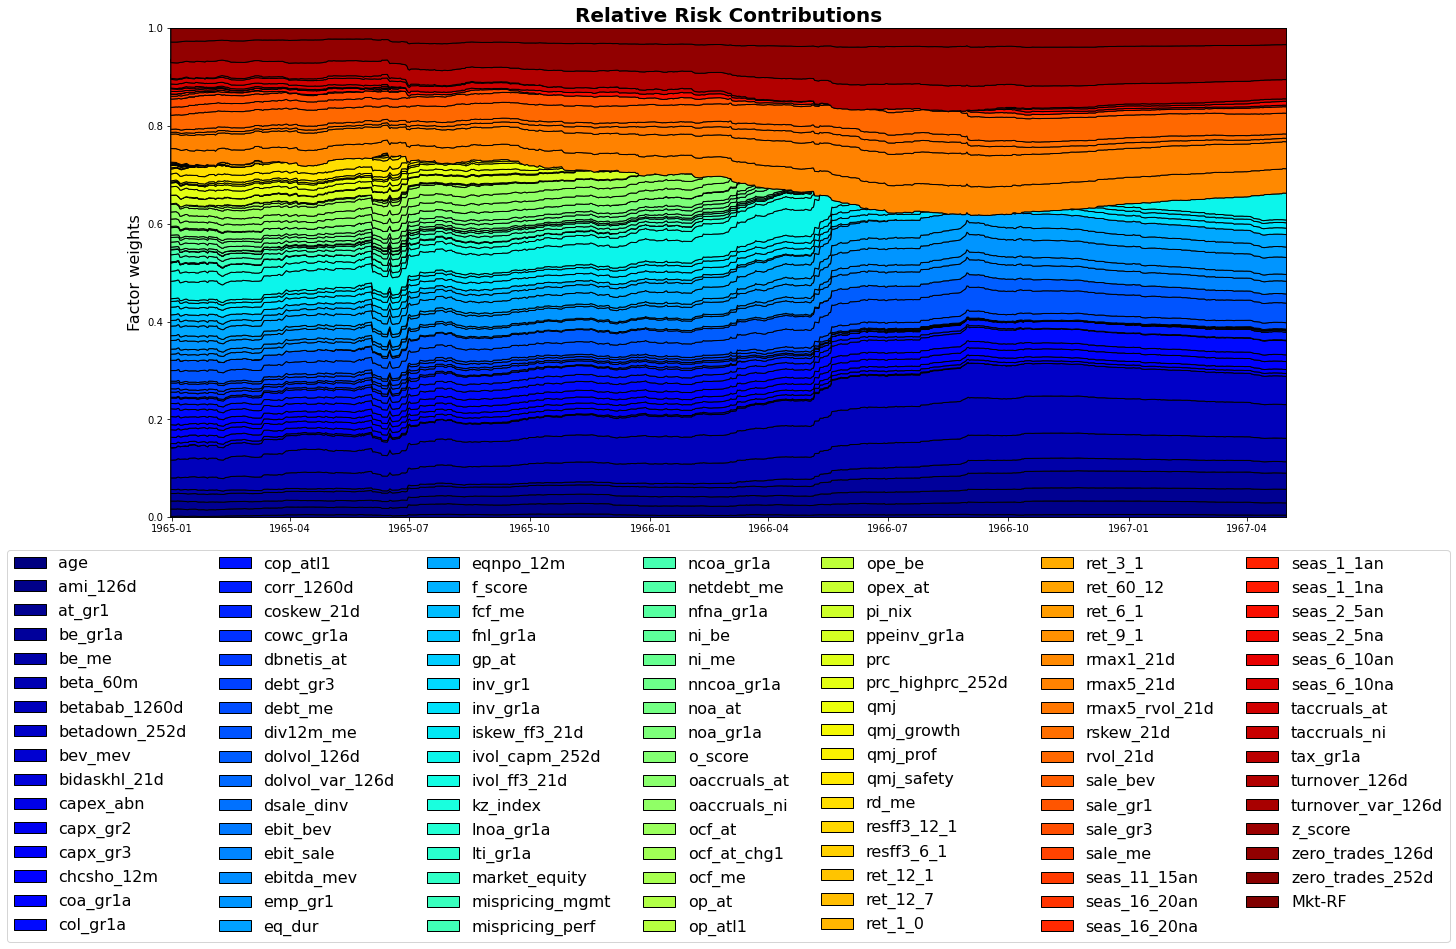

In [52]:
"""
Plot Risk contributions
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              rel_risk_contribs.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_title("Relative Risk Contributions", fontsize=20, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.set_ylabel('Factor weights', fontsize=16)
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Calculate Diversification Ratio

In [72]:
"""
Define function for portfolio std and var
"""

def calculate_portfolio_variance(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return weights @ cov_mat @ weights


def calculate_portfolio_std(weights: np.ndarray, cov_mat: np.ndarray) -> float:

    return np.sqrt(calculate_portfolio_variance(weights, cov_mat))


def cov_to_corr_matrix(cov_mat):
    
    vols = np.sqrt(np.diag(cov_mat))
    corr_mat = cov_mat / np.outer(vols, vols)
    corr_mat[corr_mat < -1], corr_mat[corr_mat > 1] = -1, 1 # numerical error 
    
    return corr_mat

In [73]:
"""
Define function to calculate the diversification ratio of Yves Choueifaty and Yves Coignard (2008)
"""

def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = calculate_portfolio_std(weights=weights, cov_mat=cov_mat)
    
    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [91]:
"""
Equally Weighted Portfolio - CC Ratios and Correlation 1
"""

cc_ratios_epo_1 = np.zeros(eff_num_periods_1)
avg_corr_1 = np.zeros(eff_num_periods_1)

upper_tri_idx_1 = np.triu_indices(num_assets_1)

"""
Perform calculations for shrunk cov_mat
"""

for t in range(eff_num_periods_1):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns_1.iloc[t: window_size + t, :].values)
    
    # convert to correlation matrix
    corr_mat = cov_to_corr_matrix(cov_mat).values
    
    # average correlation
    avg_corr_1[t] = corr_mat[upper_tri_idx_1].flatten().mean()
    
    # calculate cc ratio 
    cc_ratios_epo_1[t] = calculate_cc_ratio(w_eq_1, cov_mat)


In [92]:
"""
Equally Weighted Portfolio - CC Ratios and Correlation 2
"""

cc_ratios_epo_2 = np.zeros(eff_num_periods_2)
avg_corr_2 = np.zeros(eff_num_periods_2)

upper_tri_idx_2 = np.triu_indices(num_assets_2)

"""
Perform calculations for shrunk cov_mat
"""

for t in range(eff_num_periods_2):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns_2.iloc[t: window_size + t, :].values)
    
    # convert to correlation matrix
    corr_mat = cov_to_corr_matrix(cov_mat).values
    
    # average correlation
    avg_corr_2[t] = corr_mat[upper_tri_idx_2].flatten().mean()
    
    # calculate cc ratio 
    cc_ratios_epo_2[t] = calculate_cc_ratio(w_eq_2, cov_mat)


In [93]:
"""
Equally Weighted Portfolio - CC Ratios and Correlation 3
"""

cc_ratios_epo_3 = np.zeros(eff_num_periods_3)
avg_corr_3 = np.zeros(eff_num_periods_3)

upper_tri_idx_3 = np.triu_indices(num_assets_3)

"""
Perform calculations for shrunk cov_mat
"""

for t in range(eff_num_periods_3):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns_3.iloc[t: window_size + t, :].values)
    
    # convert to correlation matrix
    corr_mat = cov_to_corr_matrix(cov_mat).values
    
    # average correlation
    avg_corr_3[t] = corr_mat[upper_tri_idx_3].flatten().mean()
    
    # calculate cc ratio 
    cc_ratios_epo_3[t] = calculate_cc_ratio(w_eq_3, cov_mat)


In [94]:
"""
Equally Weighted Portfolio - CC Ratios and Correlation 4
"""

cc_ratios_epo_4 = np.zeros(eff_num_periods_4)
avg_corr_4 = np.zeros(eff_num_periods_4)

upper_tri_idx_4 = np.triu_indices(num_assets_4)

"""
Perform calculations for shrunk cov_mat
"""

for t in range(eff_num_periods_4):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns_4.iloc[t: window_size + t, :].values)
    
    # convert to correlation matrix
    corr_mat = cov_to_corr_matrix(cov_mat).values
    
    # average correlation
    avg_corr_4[t] = corr_mat[upper_tri_idx_4].flatten().mean()
    
    # calculate cc ratio 
    cc_ratios_epo_4[t] = calculate_cc_ratio(w_eq_4, cov_mat)


In [155]:
"""
Merge Calculations above
"""

# Merge Correlation
avg_corr = np.concatenate((avg_corr_1,avg_corr_2,avg_corr_3,avg_corr_4), axis = 0)

# Merge CC Ratio
cc_ratio_eq = np.concatenate((cc_ratios_epo_1,cc_ratios_epo_2,cc_ratios_epo_3,cc_ratios_epo_4), axis = 0)


(2040, 120)

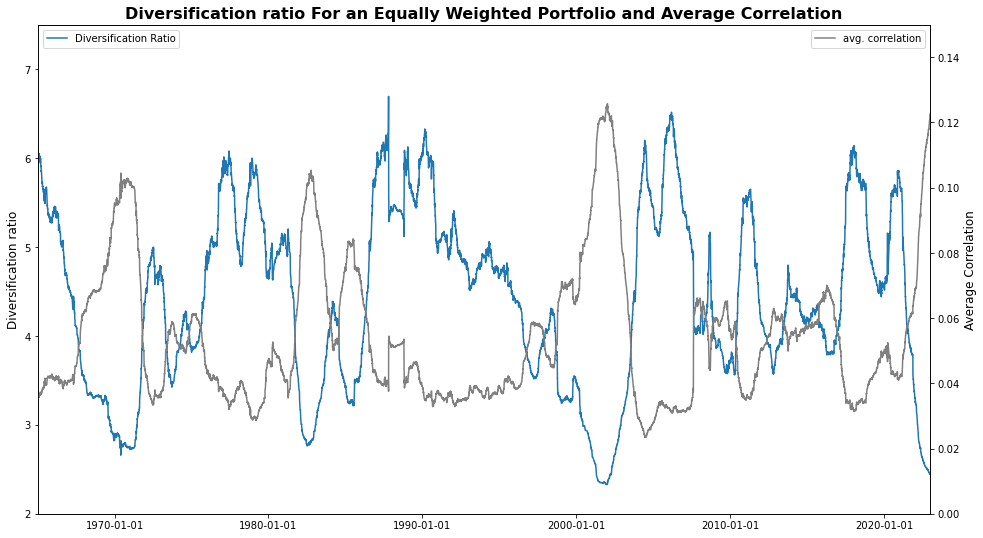

In [158]:
"""
Plot Diversification Ratio and Average Correlation
"""

fig, ax = plt.subplots(figsize=(16, 9))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.plot(returns.index[window_size:], cc_ratio_eq, label="Diversification Ratio")
ax.set_ylabel("Diversification ratio", fontsize=12)
ax.set_title("Diversification ratio For an Equally Weighted Portfolio and Average Correlation", fontsize=16, fontweight='bold');
ax.legend(loc='upper left')
ax_new = ax.twinx()
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.set_ylim(2,7.5)
ax_new.set_ylim(0,0.15)
ax_new.set_ylabel("Average Correlation", fontsize=12)
ax_new.plot(returns.index[window_size:], avg_corr, label="avg. correlation", color="gray")
ax_new.legend(loc='upper right')

# Most Diversified Portfolio

In [101]:
"""
Define function for long only portfolio
"""

def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat), init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [161]:
"""
Perform calculations for MDP with monthly rebalancing 1 
"""

most_div_port_weights_monthly_epo_1 = np.zeros((eff_num_periods_1, num_assets_1))
most_div_port_cc_monthly_epo_1 = np.zeros(eff_num_periods_1)

for t in range(eff_num_periods_1):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns_1.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo_1[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo_1[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo_1[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo_1[t, :] = most_div_port_weights_monthly_epo_1[t-1, :]
        most_div_port_cc_monthly_epo_1[t] = most_div_port_cc_monthly_epo_1[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo_1 = pd.DataFrame(data=most_div_port_weights_monthly_epo_1,
                                        index=returns_1[window_size:].index,
                                        columns=returns_1.columns)


In [162]:
"""
Perform calculations for MDP with monthly rebalancing 2
"""

most_div_port_weights_monthly_epo_2 = np.zeros((eff_num_periods_2, num_assets_2))
most_div_port_cc_monthly_epo_2 = np.zeros(eff_num_periods_2)

for t in range(eff_num_periods_2):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns_2.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo_2[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo_2[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo_2[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo_2[t, :] = most_div_port_weights_monthly_epo_2[t-1, :]
        most_div_port_cc_monthly_epo_2[t] = most_div_port_cc_monthly_epo_2[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo_2 = pd.DataFrame(data=most_div_port_weights_monthly_epo_2,
                                        index=returns_2[window_size:].index,
                                        columns=returns_2.columns)


In [163]:
"""
Perform calculations for MDP with monthly rebalancing 3
"""

most_div_port_weights_monthly_epo_3 = np.zeros((eff_num_periods_3, num_assets_3))
most_div_port_cc_monthly_epo_3 = np.zeros(eff_num_periods_3)

for t in range(eff_num_periods_3):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns_3.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo_3[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo_3[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo_3[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo_3[t, :] = most_div_port_weights_monthly_epo_3[t-1, :]
        most_div_port_cc_monthly_epo_3[t] = most_div_port_cc_monthly_epo_3[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo_3 = pd.DataFrame(data=most_div_port_weights_monthly_epo_3,
                                        index=returns_3[window_size:].index,
                                        columns=returns_3.columns)


In [164]:
"""
Perform calculations for MDP with monthly rebalancing 4
"""

most_div_port_weights_monthly_epo_4 = np.zeros((eff_num_periods_4, num_assets_4))
most_div_port_cc_monthly_epo_4 = np.zeros(eff_num_periods_4)

for t in range(eff_num_periods_4):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # calculate returns for the past 21 periods (month)
        returns_subset = returns_4.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        most_div_port_weights_monthly_epo_4[t, :] = calculate_most_diversified_portfolio(cov_mat)
        most_div_port_cc_monthly_epo_4[t] = calculate_cc_ratio(most_div_port_weights_monthly_epo_4[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        most_div_port_weights_monthly_epo_4[t, :] = most_div_port_weights_monthly_epo_4[t-1, :]
        most_div_port_cc_monthly_epo_4[t] = most_div_port_cc_monthly_epo_4[t-1]

# store in data-frame
df_most_div_port_weights_monthly_epo_4 = pd.DataFrame(data=most_div_port_weights_monthly_epo_4,
                                        index=returns_4[window_size:].index,
                                        columns=returns_4.columns)


In [208]:
"""
Download the four portfolio weights
"""

mdp_1 = most_div_port_weights_monthly_epo_1
mdp_2 = most_div_port_weights_monthly_epo_2
mdp_3 = most_div_port_weights_monthly_epo_3
mdp_4 = most_div_port_weights_monthly_epo_4

np.savetxt("most_div_port_weights_monthly_epo_1.csv", mdp_1, delimiter=",")
np.savetxt("most_div_port_weights_monthly_epo_2.csv", mdp_2, delimiter=",")
np.savetxt("most_div_port_weights_monthly_epo_3.csv", mdp_3, delimiter=",")
np.savetxt("most_div_port_weights_monthly_epo_4.csv", mdp_4, delimiter=",")

firstarray = np.genfromtxt("most_div_port_weights_monthly_epo_1.csv", delimiter=",")
firstarray = np.genfromtxt("most_div_port_weights_monthly_epo_2.csv", delimiter=",")
firstarray = np.genfromtxt("most_div_port_weights_monthly_epo_3.csv", delimiter=",")
firstarray = np.genfromtxt("most_div_port_weights_monthly_epo_4.csv", delimiter=",")


In [279]:
"""
Load MDP Weights after merging in Excel
"""

most_div_port_weights_monthly_epo_load = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/mdp weights.xlsx')
most_div_port_weights_monthly_epo = most_div_port_weights_monthly_epo_load.set_index('date')

# store in data-frame
df_most_div_port_weights_monthly_epo = pd.DataFrame(data=most_div_port_weights_monthly_epo,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

# merge cc ratio
most_div_port_cc_monthly_epo = np.concatenate((most_div_port_cc_monthly_epo_1, 
                                               most_div_port_cc_monthly_epo_2, 
                                               most_div_port_cc_monthly_epo_3, 
                                               most_div_port_cc_monthly_epo_4), axis = 0)


(0.0, 1.0)

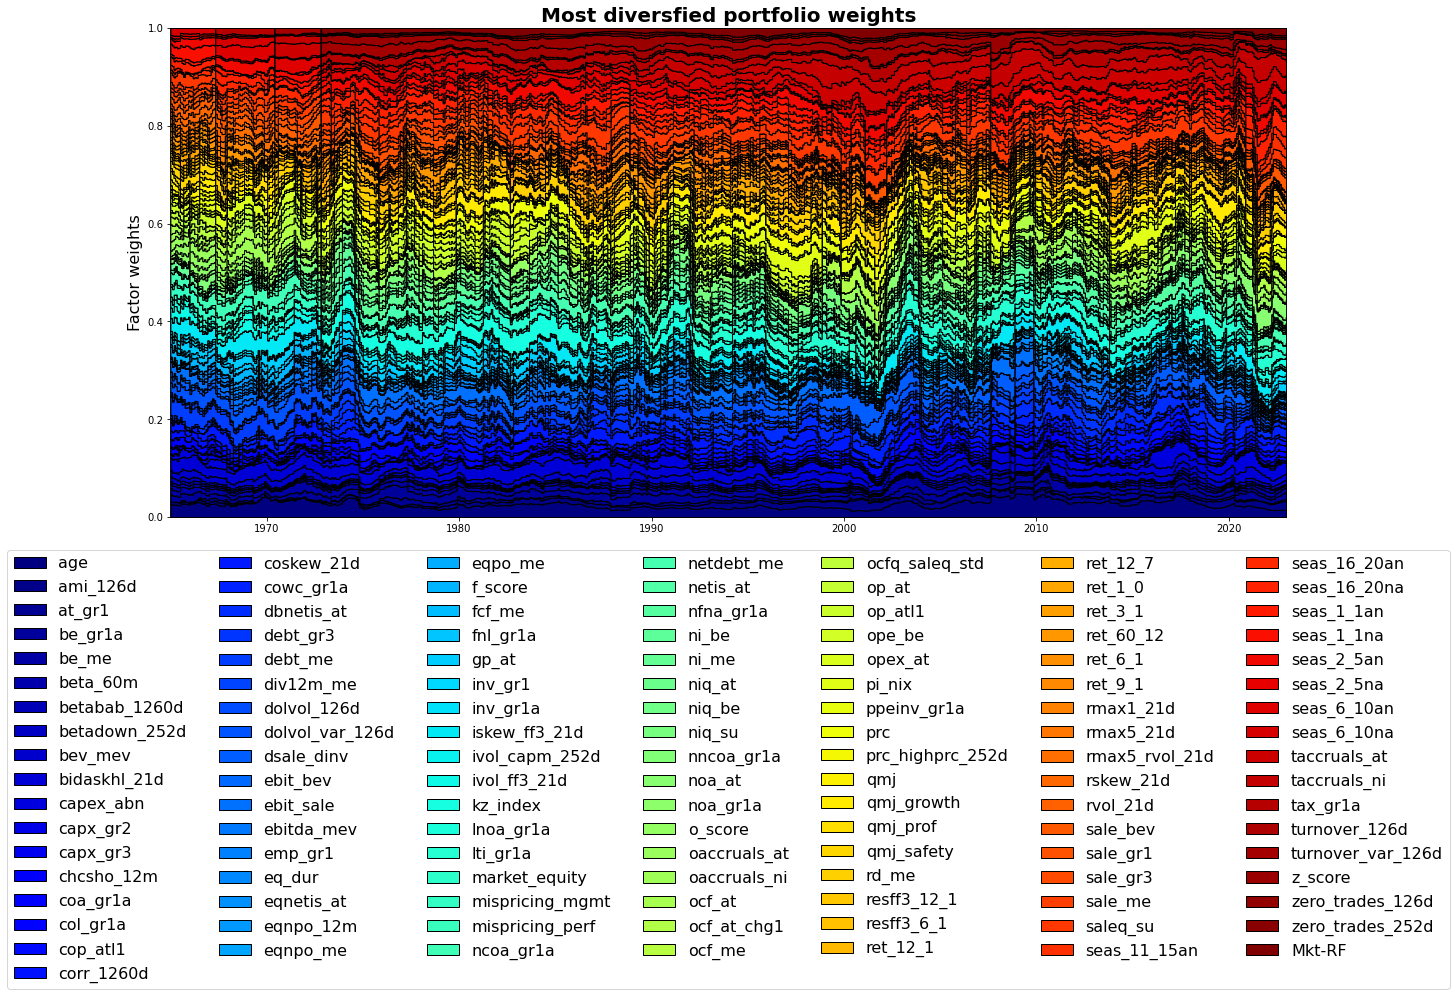

In [177]:
"""
Plot MDP Weights Monthly Rebalancing
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              most_div_port_weights_monthly_epo.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=16)
ax.set_title("Most diversfied portfolio weights",fontsize=20, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

# Minimum Variance Portfolio

In [124]:
""" 
Define function for minimum variance portfolio 
"""

def calculate_min_var_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: calculate_portfolio_variance(x, cov_mat)*100*100,
                            init_weights,
                            constraints=[eq_constraint,],
                            bounds=[(0, 1)]*n)
    
    return res.x

In [179]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing 1
"""

min_var_port_weights_monthly_epo_1 = np.zeros((eff_num_periods_1, num_assets_1))
min_var_port_cc_monthly_epo_1 = np.zeros(eff_num_periods_1)

for t in range(eff_num_periods_1):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_1.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # minimum variance portfolio
        min_var_port_weights_monthly_epo_1[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly_epo_1[t] = calculate_cc_ratio(min_var_port_weights_monthly_epo_1[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly_epo_1[t, :] = min_var_port_weights_monthly_epo_1[t-1, :]
        min_var_port_cc_monthly_epo_1[t] = min_var_port_cc_monthly_epo_1[t-1]

# store in data-frame
df_min_var_port_weights_monthly_epo_1 = pd.DataFrame(data=min_var_port_weights_monthly_epo_1,
                                        index=returns_1[window_size:].index,
                                        columns=returns_1.columns)


In [180]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing 2
"""

min_var_port_weights_monthly_epo_2 = np.zeros((eff_num_periods_2, num_assets_2))
min_var_port_cc_monthly_epo_2 = np.zeros(eff_num_periods_2)

for t in range(eff_num_periods_2):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_2.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        min_var_port_weights_monthly_epo_2[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly_epo_2[t] = calculate_cc_ratio(min_var_port_weights_monthly_epo_2[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly_epo_2[t, :] = min_var_port_weights_monthly_epo_2[t-1, :]
        min_var_port_cc_monthly_epo_2[t] = min_var_port_cc_monthly_epo_2[t-1]

# store in data-frame
df_min_var_port_weights_monthly_epo_2 = pd.DataFrame(data=min_var_port_weights_monthly_epo_2,
                                        index=returns_2[window_size:].index,
                                        columns=returns_2.columns)


In [181]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing 3
"""

min_var_port_weights_monthly_epo_3 = np.zeros((eff_num_periods_3, num_assets_3))
min_var_port_cc_monthly_epo_3 = np.zeros(eff_num_periods_3)

for t in range(eff_num_periods_3):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_3.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        min_var_port_weights_monthly_epo_3[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly_epo_3[t] = calculate_cc_ratio(min_var_port_weights_monthly_epo_3[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly_epo_3[t, :] = min_var_port_weights_monthly_epo_3[t-1, :]
        min_var_port_cc_monthly_epo_3[t] = min_var_port_cc_monthly_epo_3[t-1]

# store in data-frame
df_min_var_port_weights_monthly_epo_3 = pd.DataFrame(data=min_var_port_weights_monthly_epo_3,
                                        index=returns_3[window_size:].index,
                                        columns=returns_3.columns)


In [182]:
""" 
Perform calculations for minimum variance portfolio with monthly rebalancing 4
"""

min_var_port_weights_monthly_epo_4 = np.zeros((eff_num_periods_4, num_assets_4))
min_var_port_cc_monthly_epo_4 = np.zeros(eff_num_periods_4)

for t in range(eff_num_periods_4):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_4.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        min_var_port_weights_monthly_epo_4[t, :] = calculate_min_var_portfolio(cov_mat)
        min_var_port_cc_monthly_epo_4[t] = calculate_cc_ratio(min_var_port_weights_monthly_epo_4[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        min_var_port_weights_monthly_epo_4[t, :] = min_var_port_weights_monthly_epo_4[t-1, :]
        min_var_port_cc_monthly_epo_4[t] = min_var_port_cc_monthly_epo_4[t-1]

# store in data-frame
df_min_var_port_weights_monthly_epo_4 = pd.DataFrame(data=min_var_port_weights_monthly_epo_4,
                                        index=returns_4[window_size:].index,
                                        columns=returns_4.columns)


In [183]:
"""
Merge Min_Var Calculations
"""

# determine the maximum number of columns
max_cols = max(min_var_port_weights_monthly_epo_1.shape[1], 
                min_var_port_weights_monthly_epo_2.shape[1], 
                min_var_port_weights_monthly_epo_3.shape[1], 
                min_var_port_weights_monthly_epo_4.shape[1])

# pad the arrays with zeros to the maximum number of columns
min_var_port_weights_monthly_epo_1_padded = np.pad(min_var_port_weights_monthly_epo_1, 
                                                    ((0, 0), (0, max_cols - min_var_port_weights_monthly_epo_1.shape[1])), 
                                                    mode='constant', constant_values=0)

min_var_port_weights_monthly_epo_2_padded = np.pad(min_var_port_weights_monthly_epo_2, 
                                                    ((0, 0), (0, max_cols - min_var_port_weights_monthly_epo_2.shape[1])), 
                                                    mode='constant', constant_values=0)

min_var_port_weights_monthly_epo_3_padded = np.pad(min_var_port_weights_monthly_epo_3, 
                                                    ((0, 0), (0, max_cols - min_var_port_weights_monthly_epo_3.shape[1])), 
                                                    mode='constant', constant_values=0)

min_var_port_weights_monthly_epo_4_padded = np.pad(min_var_port_weights_monthly_epo_4, 
                                                    ((0, 0), (0, max_cols - min_var_port_weights_monthly_epo_4.shape[1])), 
                                                    mode='constant', constant_values=0)


# concatenate the arrays vertically
min_var_port_weights_monthly_epo = np.concatenate((min_var_port_weights_monthly_epo_1_padded, 
                                                    min_var_port_weights_monthly_epo_2_padded,
                                                    min_var_port_weights_monthly_epo_3_padded,
                                                    min_var_port_weights_monthly_epo_4_padded), axis=0)

# merge cc ratio
min_var_port_cc_monthly_epo = np.concatenate((min_var_port_cc_monthly_epo_1, 
                                               min_var_port_cc_monthly_epo_2, 
                                               min_var_port_cc_monthly_epo_3, 
                                               min_var_port_cc_monthly_epo_4), axis = 0)


In [269]:
"""
Download the four portfolio weights
"""

min_1 = min_var_port_weights_monthly_epo_1
min_2 = min_var_port_weights_monthly_epo_2
min_3 = min_var_port_weights_monthly_epo_3
min_4 = min_var_port_weights_monthly_epo_4

np.savetxt("min_var_port_weights_monthly_epo_1.csv", min_1, delimiter=",")
np.savetxt("min_var_port_weights_monthly_epo_2.csv", min_2, delimiter=",")
np.savetxt("min_var_port_weights_monthly_epo_3.csv", min_3, delimiter=",")
np.savetxt("min_var_port_weights_monthly_epo_4.csv", min_4, delimiter=",")

firstarray = np.genfromtxt("min_var_port_weights_monthly_epo_1.csv", delimiter=",")
firstarray = np.genfromtxt("min_var_port_weights_monthly_epo_2.csv", delimiter=",")
firstarray = np.genfromtxt("min_var_port_weights_monthly_epo_3.csv", delimiter=",")
firstarray = np.genfromtxt("min_var_port_weights_monthly_epo_4.csv", delimiter=",")


In [278]:
"""
Load Minimum Variance Weights after merging in Excel
"""

min_var_port_weights_monthly_epo_load = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/min weights.xlsx')
min_var_port_weights_monthly_epo = min_var_port_weights_monthly_epo_load.set_index('date')

# store in data-frame
df_min_var_port_weights_monthly_epo = pd.DataFrame(data=min_var_port_weights_monthly_epo,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

# merge cc ratio
min_var_port_cc_monthly_epo = np.concatenate((min_var_port_cc_monthly_epo_1, 
                                               min_var_port_cc_monthly_epo_2, 
                                               min_var_port_cc_monthly_epo_3, 
                                               min_var_port_cc_monthly_epo_4), axis = 0)


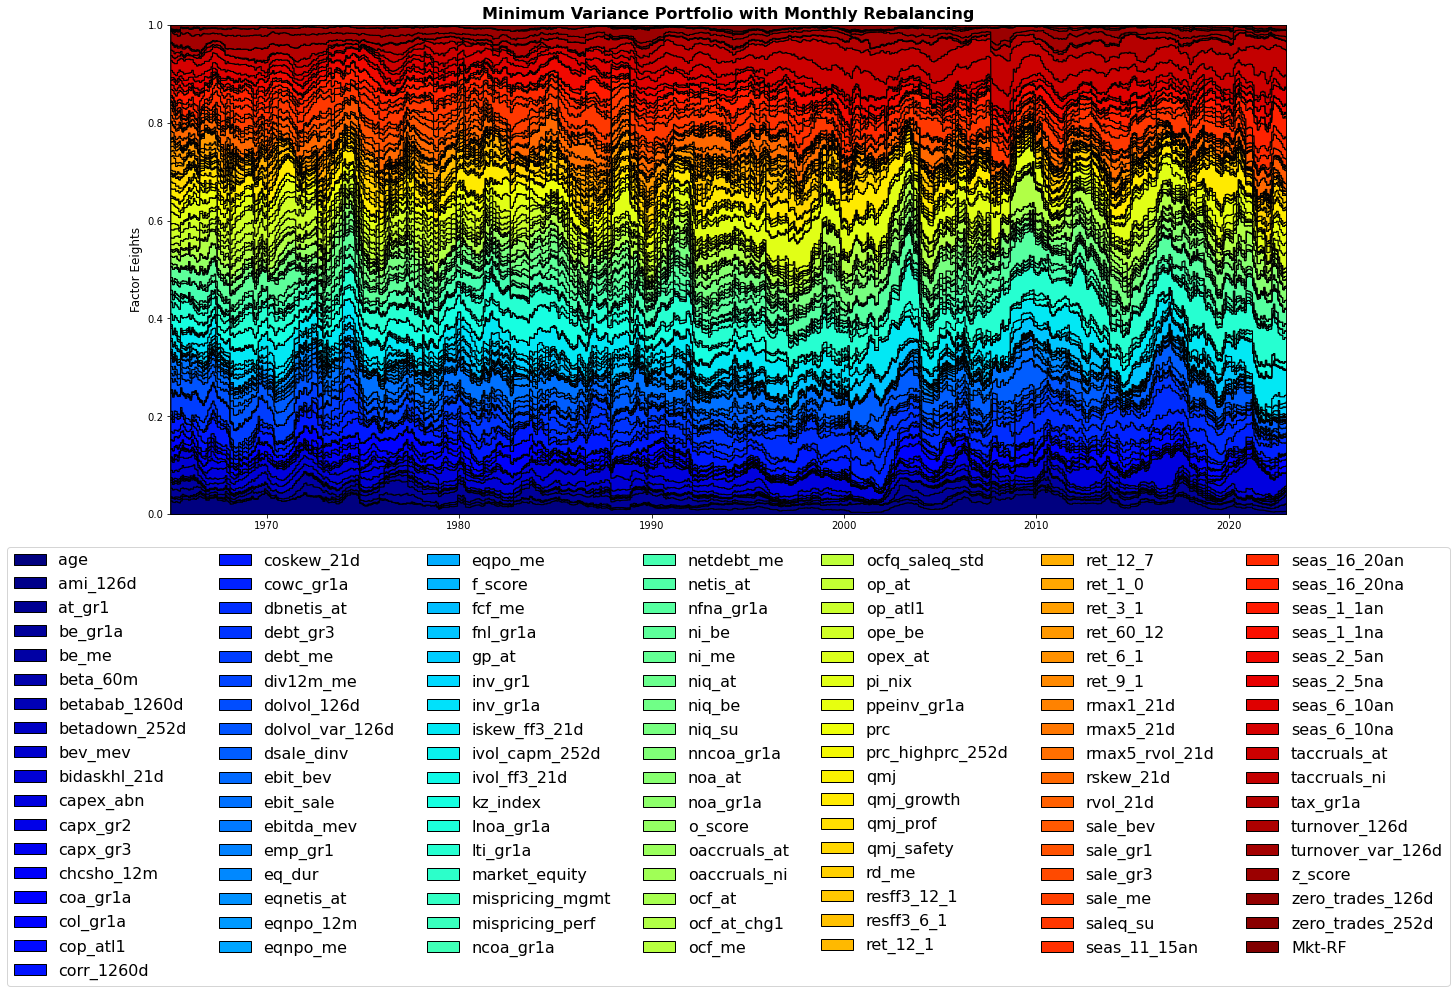

In [276]:
""" 
Plot Minimum Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_monthly_epo.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Eeights', fontsize=12)
ax.set_title("Minimum Variance Portfolio with Monthly Rebalancing", fontsize=16, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');

# Mean-Variance Portfolio (Max Sharpe Ratio)

In [185]:
"""
Define Function for Tangency Portfolio - Mean-Variance Portfolio
"""

def tangency_portfolio(cov_mat: np.ndarray, returns: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights subject to no shorting.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    returns: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights subject to no shorting.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)
    mu = np.mean(returns, axis=0)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)

    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    # define no shorting constraint
    bounds = [(0, None) for i in range(num_assets)]
    
    # define objective function
    def neg_sharpe_ratio(weights, excess_mu, cov_mat_inv):
        p_return = np.dot(excess_mu, weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
        return -(p_return / p_volatility)

    result = optimize.minimize(neg_sharpe_ratio, np.repeat(1.0 / num_assets, num_assets), 
                               args=(excess_mu, cov_mat_inv), method='SLSQP', bounds=bounds, constraints=eq_constraint)
    
    w_max_sr = result.x
    
    return w_max_sr

In [186]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing 1
"""

mean_var_port_weights_monthly_1 = np.zeros((eff_num_periods_1, num_assets_1))
mean_var_port_cc_monthly_1 = np.zeros(eff_num_periods_1)

for t in range(eff_num_periods_1):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_1.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly_1[t, :] = tangency_portfolio(cov_mat, returns_subset, 0)
        mean_var_port_cc_monthly_1[t] = calculate_cc_ratio(mean_var_port_weights_monthly_1[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly_1[t, :] = mean_var_port_weights_monthly_1[t-1, :]
        mean_var_port_cc_monthly_1[t] = mean_var_port_cc_monthly_1[t-1]

# store in data-frame
df_mean_var_port_weights_monthly_1 = pd.DataFrame(data=mean_var_port_weights_monthly_1,
                                        index=returns_1[window_size:].index,
                                        columns=returns_1.columns)


In [187]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing 2
"""

mean_var_port_weights_monthly_2 = np.zeros((eff_num_periods_2, num_assets_2))
mean_var_port_cc_monthly_2 = np.zeros(eff_num_periods_2)

for t in range(eff_num_periods_2):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_2.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly_2[t, :] = tangency_portfolio(cov_mat, returns_subset, 0)
        mean_var_port_cc_monthly_2[t] = calculate_cc_ratio(mean_var_port_weights_monthly_2[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly_2[t, :] = mean_var_port_weights_monthly_2[t-1, :]
        mean_var_port_cc_monthly_2[t] = mean_var_port_cc_monthly_2[t-1]

# store in data-frame
df_mean_var_port_weights_monthly_2 = pd.DataFrame(data=mean_var_port_weights_monthly_2,
                                        index=returns_2[window_size:].index,
                                        columns=returns_2.columns)


In [188]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing 3
"""

mean_var_port_weights_monthly_3 = np.zeros((eff_num_periods_3, num_assets_3))
mean_var_port_cc_monthly_3 = np.zeros(eff_num_periods_3)

for t in range(eff_num_periods_3):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_3.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly_3[t, :] = tangency_portfolio(cov_mat, returns_subset, 0)
        mean_var_port_cc_monthly_3[t] = calculate_cc_ratio(mean_var_port_weights_monthly_3[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly_3[t, :] = mean_var_port_weights_monthly_3[t-1, :]
        mean_var_port_cc_monthly_3[t] = mean_var_port_cc_monthly_3[t-1]

# store in data-frame
df_mean_var_port_weights_monthly_3 = pd.DataFrame(data=mean_var_port_weights_monthly_3,
                                        index=returns_3[window_size:].index,
                                        columns=returns_3.columns)


In [189]:
""" 
Perform calculations for tangency portfolio with monthly rebalancing 4
"""

mean_var_port_weights_monthly_4 = np.zeros((eff_num_periods_4, num_assets_4))
mean_var_port_cc_monthly_4 = np.zeros(eff_num_periods_4)

for t in range(eff_num_periods_4):
    if t % 21 == 0:  # rebalance every 21 periods (monthly)
        
        # Define returns in window range
        returns_subset = returns_4.iloc[t: window_size + t, :].values
        
        # covariance matrix
        cov_mat = shrunk_cov_mat(returns_subset)
        
        # most diversified portfolio
        mean_var_port_weights_monthly_4[t, :] = tangency_portfolio(cov_mat, returns_subset, 0)
        mean_var_port_cc_monthly_4[t] = calculate_cc_ratio(mean_var_port_weights_monthly_4[t, :], cov_mat)
        
    else:
        # use previous weights for non-rebalancing periods
        mean_var_port_weights_monthly_4[t, :] = mean_var_port_weights_monthly_4[t-1, :]
        mean_var_port_cc_monthly_4[t] = mean_var_port_cc_monthly_4[t-1]

# store in data-frame
df_mean_var_port_weights_monthly_4 = pd.DataFrame(data=mean_var_port_weights_monthly_4,
                                        index=returns_4[window_size:].index,
                                        columns=returns_4.columns)


In [281]:
"""
Download the four portfolio weights
"""

mean_1 = mean_var_port_weights_monthly_1
mean_2 = mean_var_port_weights_monthly_2
mean_3 = mean_var_port_weights_monthly_3
mean_4 = mean_var_port_weights_monthly_4

np.savetxt("mean_var_port_weights_monthly_1.csv", mean_1, delimiter=",")
np.savetxt("mean_var_port_weights_monthly_2.csv", mean_2, delimiter=",")
np.savetxt("mean_var_port_weights_monthly_3.csv", mean_3, delimiter=",")
np.savetxt("mean_var_port_weights_monthly_4.csv", mean_4, delimiter=",")

firstarray = np.genfromtxt("mean_var_port_weights_monthly_1.csv", delimiter=",")
firstarray = np.genfromtxt("mean_var_port_weights_monthly_2.csv", delimiter=",")
firstarray = np.genfromtxt("mean_var_port_weights_monthly_3.csv", delimiter=",")
firstarray = np.genfromtxt("mean_var_port_weights_monthly_4.csv", delimiter=",")


In [282]:
"""
Load Minimum Variance Weights after merging in Excel
"""

mean_var_port_weights_monthly_load = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/mean weights.xlsx')
mean_var_port_weights_monthly = mean_var_port_weights_monthly_load.set_index('date')

# store in data-frame
df_mean_var_port_weights_monthly = pd.DataFrame(data=mean_var_port_weights_monthly,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

# merge cc ratio
mean_var_port_cc_monthly = np.concatenate((mean_var_port_cc_monthly_1, 
                                               mean_var_port_cc_monthly_2, 
                                               mean_var_port_cc_monthly_3, 
                                               mean_var_port_cc_monthly_4), axis = 0)


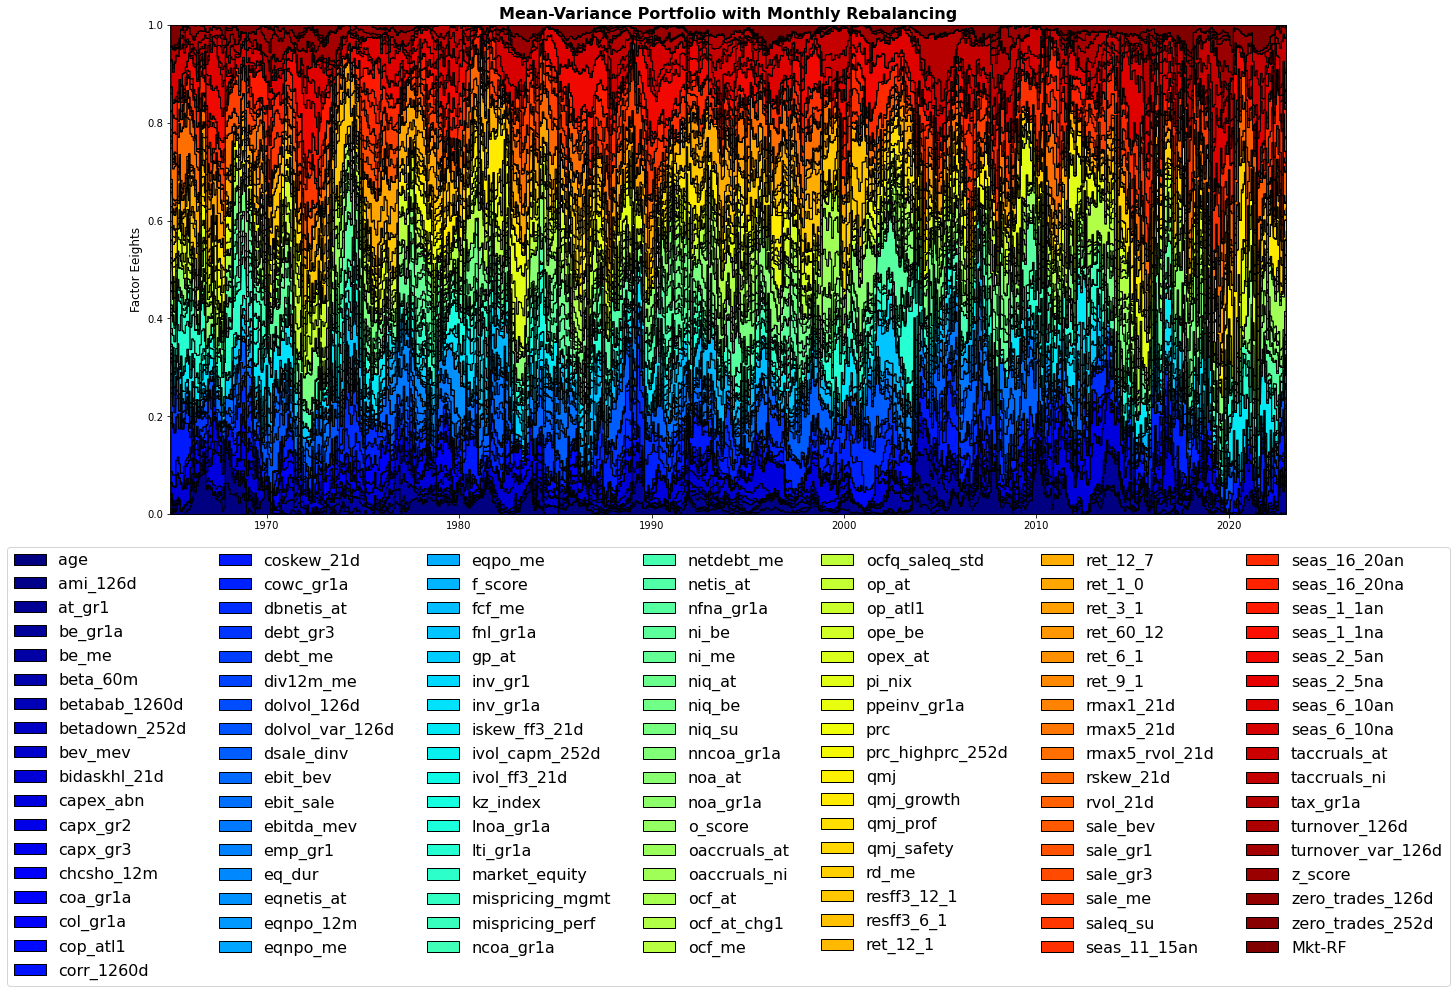

In [283]:
""" 
Plot Mean-Variance Weights with monthly rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              mean_var_port_weights_monthly.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor Eeights', fontsize=12)
ax.set_title("Mean-Variance Portfolio with Monthly Rebalancing", fontsize=16, fontweight='bold');
ax.set_ylim(0,1)
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');

# Determining The Right Covariance Estimation Going Forward

In [528]:
"""
Select the portfolio weights for the given covariance estamation below and continue the analysis
"""

# Simple Covariance Matrix:

"""cc_ratios_simple_cov

most_div_port_weights_monthly_simple_cov
most_div_port_cc_monthly_simple_cov

min_var_port_weights_monthly_simple_cov
min_var_port_cc_monthly_simple_cov
"""

# Exponential Decaying Covariance Matrix:

"""cc_ratios_decaying

most_div_port_weights_monthly_decaying
most_div_port_cc_monthly_decaying

min_var_port_weights_monthly_decaying
min_var_port_cc_monthly_decaying
"""

# Ledoit and Wolf 

"""cc_ratios_lw

most_div_port_weights_monthly_lw
most_div_port_cc_monthly_lw

min_var_port_weights_monthly_lw
min_var_port_cc_monthly_lw
"""

# Enhanced Portfolio Optimization

"""cc_ratios_epo

most_div_port_weights_monthly_epo
most_div_port_cc_monthly_epo

min_var_port_weights_monthly_epo
min_var_port_cc_monthly_epo
"""

'\nSelect the portfolio weights for the given covariance estamation below and continue the analysis\n'

# Diversifaction Ratio For All Portfolios

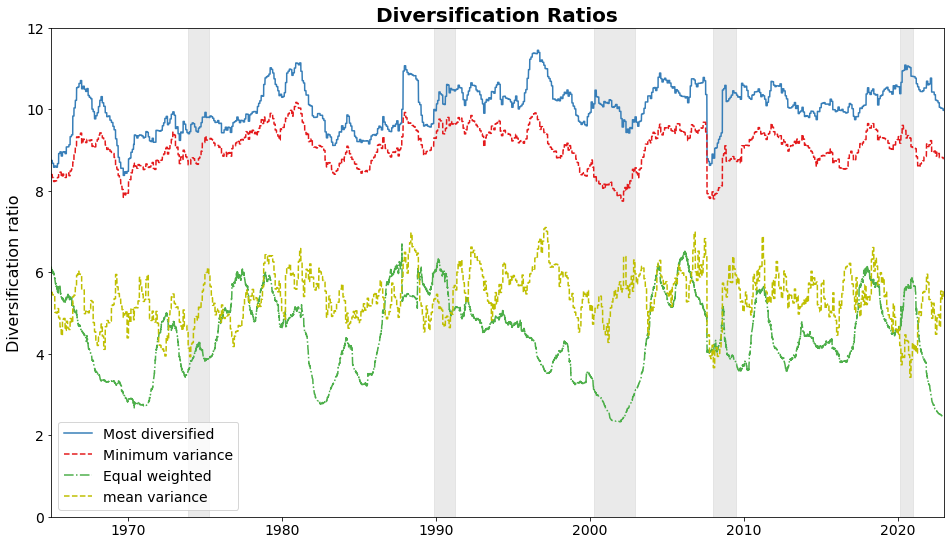

In [293]:
"""
Plot the Diversification Ratios
"""

# Define colors
most_div_color = "#377eb8"
min_var_color = "#e41a1c"
cc_color = "#4daf4a"
gray_color = "#cccccc"

# Define line styles
most_div_linestyle = "-"
min_var_linestyle = "--"
cc_linestyle = "-."

# Plotting Diversification Ratios
fig, ax = plt.subplots(figsize=(16, 9))

# Plot diversification ratios
ax.plot(returns.index[window_size:], most_div_port_cc_monthly_epo, label="Most diversified", color=most_div_color, linestyle=most_div_linestyle)
ax.plot(returns.index[window_size:], min_var_port_cc_monthly_epo, label="Minimum variance", color=min_var_color, linestyle=min_var_linestyle)
ax.plot(returns.index[window_size:], cc_ratio_eq, label="Equal weighted", color=cc_color, linestyle=cc_linestyle)
ax.plot(returns.index[window_size:], mean_var_port_cc_monthly, label="mean variance", color='y', linestyle=min_var_linestyle)


# Set y-axis label and title
ax.set_ylabel("Diversification ratio", fontsize=16)
ax.set_title("Diversification Ratios", fontweight="bold", fontsize=20)

# Set y-axis limits
ax.set_ylim(0, 12)

# Add legend
ax.legend(fontsize=14)

# Fill empty spaces
ax.set_xlim(returns.index[window_size], returns.index[-1])

# Define recession periods
tech_bubble_start = pd.to_datetime("2000-03-31").strftime('%Y-%m-%d')
tech_bubble_end = pd.to_datetime("2002-11-30").strftime('%Y-%m-%d')
financial_crisis_start = pd.to_datetime("2007-12-31").strftime('%Y-%m-%d')
financial_crisis_end = pd.to_datetime("2009-06-30").strftime('%Y-%m-%d')
covid_start = pd.to_datetime("2020-02-29").strftime('%Y-%m-%d')
covid_end = pd.to_datetime("2020-12-31").strftime('%Y-%m-%d')
oil_crisis_start = pd.to_datetime("1973-11-30").strftime('%Y-%m-%d')
oil_crisis_end = pd.to_datetime("1975-03-31").strftime('%Y-%m-%d')
savings_loan_crisis_start = pd.to_datetime("1989-11-30").strftime('%Y-%m-%d')
savings_loan_crisis_end = pd.to_datetime("1991-03-31").strftime('%Y-%m-%d')

# Add vertical shaded regions for recession periods
ax.axvspan(tech_bubble_start, tech_bubble_end, alpha=0.4, color=gray_color)
ax.axvspan(financial_crisis_start, financial_crisis_end, alpha=0.4, color=gray_color)
ax.axvspan(covid_start, covid_end, alpha=0.4, color=gray_color)
ax.axvspan(oil_crisis_start, oil_crisis_end, alpha=0.4, color=gray_color)
ax.axvspan(savings_loan_crisis_start, savings_loan_crisis_end, alpha=0.4, color=gray_color)


# Set font size of ticks
ax.tick_params(labelsize=14)


# In-Sample Performance

In [243]:
"""
Load weights
"""
# Equal Weights
eq_weights = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/eq_weights.xlsx')
equal_weights = eq_weights.set_index('date')


In [303]:
"""
Combine In-Sample Portfolios into one Dataframe
"""

df_port_ret_in_sample = pd.DataFrame(index=returns.index)

cov_mat = shrunk_cov_mat(returns)

# Combine portfolios
df_port_ret_in_sample['min-var'] = (returns * calculate_min_var_portfolio(cov_mat)).sum(axis=1)
df_port_ret_in_sample['most-div'] = (returns * calculate_most_diversified_portfolio(cov_mat)).sum(axis=1)
df_port_ret_in_sample['mean-var'] = (returns * tangency_portfolio(cov_mat, returns, 0)).sum(axis=1)
df_port_ret_in_sample['eq-weight'] = (returns * equal_weights).sum(axis=1)

"""
Perfromance Evaluation
"""

# Transform daily returns to monthly
df_port_ret_in_sample_monthly = (1 + df_port_ret_in_sample).resample('M').prod() - 1

# Compute Mean
mean_return_in_sample = df_port_ret_in_sample_monthly.mean(axis=0)
mean_return_in_sample.name = "Mean Return"

# Compute Standard Deviation
std_return_in_sample = df_port_ret_in_sample_monthly.std(axis=0)
std_return_in_sample.name = "Standard Deviation"

# Compute Sharpe Ratio
sharpe_ratio_in_sample = (mean_return_in_sample / std_return_in_sample) * np.sqrt(12)
sharpe_ratio_in_sample.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_df = pd.concat([mean_return_in_sample, std_return_in_sample, sharpe_ratio_in_sample], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(df_port_ret_in_sample_monthly.round(4))
print("\nPerformance Metrics:")
print(result_df.round(4))

Monthly Portfolio Returns:
            min-var  most-div  mean-var  eq-weight
date                                              
1964-01-31   0.0031    0.0026    0.0075     0.0056
1964-02-29   0.0017    0.0017    0.0042     0.0015
1964-03-31   0.0042    0.0035    0.0070     0.0069
1964-04-30  -0.0017   -0.0006   -0.0025     0.0009
1964-05-31   0.0004    0.0009    0.0019     0.0014
...             ...       ...       ...        ...
2022-08-31   0.0016    0.0006    0.0029    -0.0067
2022-09-30   0.0004    0.0006    0.0027     0.0067
2022-10-31   0.0060    0.0057    0.0081     0.0160
2022-11-30  -0.0016   -0.0011   -0.0005     0.0088
2022-12-31   0.0001    0.0002    0.0019     0.0107

[708 rows x 4 columns]

Performance Metrics:
           Mean Return  Standard Deviation  Sharpe Ratio
min-var         0.0016              0.0026        2.1587
most-div        0.0017              0.0025        2.3111
mean-var        0.0031              0.0043        2.5111
eq-weight       0.0025              

# Evaluating Strategies Out-Of-Sample

In [288]:
"""
Combine Portfolios into one Dataframe
"""

df_port_ret = pd.DataFrame(index=returns.index[window_size:])

# Combine portfolios
df_port_ret['min-var'] = (returns[window_size:] * df_min_var_port_weights_monthly_epo).sum(axis=1)
df_port_ret['most-div'] = (returns[window_size:] * df_most_div_port_weights_monthly_epo).sum(axis=1)
df_port_ret['mean-var'] = (returns[window_size:] * df_mean_var_port_weights_monthly).sum(axis=1)
df_port_ret['eq-weight'] = (returns[window_size:] * equal_weights[window_size:]).sum(axis=1)

# Calculate cumulative return
df_port_tri = (1 + df_port_ret).cumprod(axis=0) # probably not the correct way
df_port_cum = df_port_ret.cumsum(axis=0) # Only okay for plotting cumulative returns
df_port_cum

min-var  most-div  mean-var  eq-weight
date                                               
1964-12-31 -0.000059  0.000011  0.000013   0.000039
1965-01-04  0.000520  0.000530  0.000536   0.000332
1965-01-05  0.000927  0.000926  0.001149   0.000584
1965-01-06  0.001350  0.001364  0.002123   0.001063
1965-01-07  0.001363  0.001453  0.002388   0.000748
...              ...       ...       ...        ...
2022-12-23  0.966364  0.990968  2.201912   1.708442
2022-12-27  0.966587  0.991081  2.204255   1.714235
2022-12-28  0.966630  0.990977  2.203354   1.712789
2022-12-29  0.966185  0.990615  2.201536   1.705944
2022-12-30  0.966558  0.991109  2.201306   1.705076

[14601 rows x 4 columns]

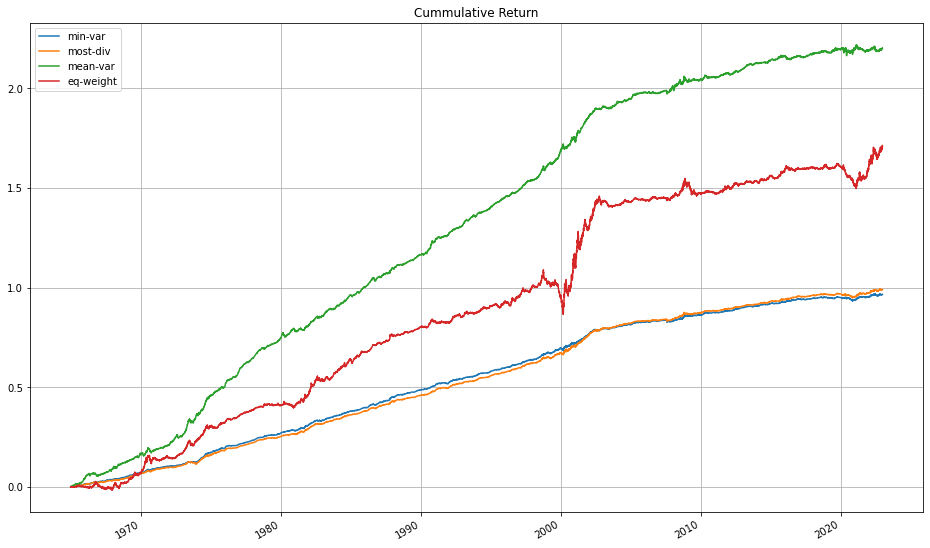

In [289]:
"""
Plot Cumulative Returns
"""

df_port_cum.plot(xlabel="", figsize=(16, 10), title="Cummulative Return", grid='True');

In [306]:
"""
Perfromance Evaluation
"""

# Transform daily returns to monthly
df_port_ret_monthly = (1 + df_port_ret).resample('Y').prod() - 1

# Compute Mean
mean_return = df_port_ret_monthly.mean(axis=0)
mean_return.name = "Mean Return"

# Compute Standard Deviation
std_return = df_port_ret_monthly.std(axis=0)
std_return.name = "Standard Deviation"

# Compute Sharpe Ratio
sharpe_ratio = (mean_return / std_return)
sharpe_ratio.name = "Sharpe Ratio"

# Combine the results into a DataFrame
result_df = pd.concat([mean_return, std_return, sharpe_ratio], axis=1)

# Print the results
print("Monthly Portfolio Returns:")
print(df_port_ret_monthly.round(4))
print("\nPerformance Metrics:")
print(result_df.round(4))

Monthly Portfolio Returns:
            min-var  most-div  mean-var  eq-weight
date                                              
1964-12-31  -0.0001    0.0000    0.0000     0.0000
1965-12-31   0.0142    0.0126    0.0411    -0.0003
1966-12-31   0.0095    0.0093    0.0191     0.0093
1967-12-31   0.0134    0.0103    0.0317    -0.0207
1968-12-31   0.0149    0.0133    0.0375     0.0343
1969-12-31   0.0200    0.0211    0.0388     0.0475
1970-12-31   0.0200    0.0189    0.0188     0.0771
1971-12-31   0.0111    0.0115    0.0241     0.0023
1972-12-31   0.0101    0.0117    0.0517     0.0226
1973-12-31   0.0112    0.0084    0.1108     0.0628
1974-12-31   0.0506    0.0433    0.0979     0.0747
1975-12-31   0.0214    0.0236    0.0454     0.0196
1976-12-31   0.0192    0.0194    0.0765     0.0334
1977-12-31   0.0220    0.0223    0.0725     0.0325
1978-12-31   0.0214    0.0201    0.0577     0.0274
1979-12-31   0.0139    0.0096    0.0474    -0.0041
1980-12-31   0.0129    0.0119    0.0419    -0.0084
1981

# Test For Stationarity

In [674]:
"""
Perform Dickey Fuller Test on Equally Weighted
"""

eq_ret = df_port_ret['eq-weight']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(eq_ret)

ADF Statistic: -15.618823093521184
p-value: 1.7422830911592594e-28
Critical Values:
	1%: -3.4353824418821852
	5%: -2.863762408248617
	10%: -2.567953223847985
Null hypothesis rejected. Data is stationary.


In [675]:
"""
Perform Dickey Fuller Test on MDP
"""

mdp_ret = df_port_ret['most-div']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(mdp_ret)

ADF Statistic: -33.78439478403261
p-value: 0.0
Critical Values:
	1%: -3.4353708501743654
	5%: -2.8637572934525286
	10%: -2.56795049999266
Null hypothesis rejected. Data is stationary.


In [676]:
"""
Perform Dickey Fuller Test on Minimum Variance
"""

mv_ret = df_port_ret['min-var']

# Define the ADF test function
def adf_test(x):
    result = adfuller(x)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] < 0.05:
        print('Null hypothesis rejected. Data is stationary.')
    else:
        print('Failed to reject null hypothesis. Data is non-stationary.')

# Apply the ADF test to your portfolio returns
adf_test(mv_ret)

ADF Statistic: nan
p-value: nan
Critical Values:
	1%: -3.4353708501743654
	5%: -2.8637572934525286
	10%: -2.56795049999266
Failed to reject null hypothesis. Data is non-stationary.


/Users/christoffer/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [141]:
"""
KPSS Test for Stationarity
"""

# assuming your portfolio returns are stored in a variable called 'returns'
lags = 20 # set the number of lags to use in the KPSS test
kpss_test = kpss(eq_ret, regression='c', nlags=lags)

print('KPSS statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('lags:', kpss_test[2])
print('Critical values:')
for key, value in kpss_test[3].items():
    print(f'   {key}: {value:.3f}')

if kpss_test[1] < 0.05:
    print('The portfolio returns are not stationary.')
else:
    print('The portfolio returns are stationary.')

KPSS statistic: 0.30926787053830446
p-value: 0.1
lags: 20
Critical values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The portfolio returns are stationary.


/Users/christoffer/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# CAPM Regressions

In [265]:
"""
Load Fama-French Three-Factor Model
"""

# Resample portfolio returns to run a regression model on monthly returns
df_port_ret_monthly = df_port_ret.resample('M').apply(lambda x: (x + 1).prod() - 1)

# Load the Fama-French three-factor data
df_ff5 = pd.read_excel('/Users/christoffer/Desktop/CBS/Cand.merc Finance & Investments/Thesis/Kodning/ff5.xlsx').set_index('date')

# Merge the portfolio returns and Fama-French data
df_rets_ff5 = pd.merge(df_port_ret_monthly, df_ff5, on='date')
df_rets_ff5

min-var  most-div  mean-var  eq-weight  Mkt-RF     SMB     HML  \
date                                                                          
1999-01-31  0.002368  0.001581  0.012219  -0.015642  0.0350 -0.0074 -0.0460   
1999-02-28  0.000680  0.000310  0.002644   0.009462 -0.0408 -0.0523  0.0192   
1999-03-31 -0.002533 -0.004086  0.006539  -0.014097  0.0345 -0.0423 -0.0274   
1999-04-30 -0.001912 -0.002615 -0.006571  -0.004683  0.0433  0.0453  0.0246   
1999-05-31  0.004195  0.004139 -0.002776   0.009213 -0.0246  0.0371  0.0235   
...              ...       ...       ...        ...     ...     ...     ...   
2022-08-31  0.001361  0.001103 -0.002821  -0.006900 -0.0377  0.0149  0.0030   
2022-09-30  0.002364  0.002731 -0.002241   0.006712 -0.0935 -0.0097  0.0006   
2022-10-31  0.004637  0.004670  0.009078   0.016098  0.0783  0.0186  0.0805   
2022-11-30 -0.002493 -0.002340  0.002573   0.008906  0.0460 -0.0267  0.0138   
2022-12-31  0.002368  0.002145  0.007635   0.010925 -0.0641 -0.0016  0.0132   

               RMW     CMA      RF  
date                                
1999-01-31 -0.0279 -0.0677  0.0035  
1999-02-28 -0.0121  0.0407  0.0035  
1999-03-31 -0.0407 -0.0141  0.0043  
1999-04-30 -0.0253  0.0090  0.0037  
1999-05-31  0.0093  0.0333  0.0034  
...            ...     ...     ...  
2022-08-31 -0.0478  0.0130  0.0019  
2022-09-30 -0.0151 -0.0084  0.0019  
2022-10-31  0.0307  0.0652  0.0023  
2022-11-30  0.0601  0.0311  0.0029  
2022-12-31  0.0009  0.0419  0.0033  

[288 rows x 10 columns]

In [203]:
"""
Perform Regression on Equally Weighted Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_ff5['eq-weight']
X = df_rets_ff5[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              eq-weight   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     104.8
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           3.71e-21
Time:                        13:13:38   Log-Likelihood:                 839.00
No. Observations:                 288   AIC:                            -1674.
Df Residuals:                     286   BIC:                            -1667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      4.238      0.0

In [266]:
"""
Perform Regression on Mean-Variance Portfolio Against Fama-French CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_ff5['mean-var']
X = df_rets_ff5[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               mean-var   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     12.16
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           0.000565
Time:                        19:38:28   Log-Likelihood:                 1017.1
No. Observations:                 288   AIC:                            -2030.
Df Residuals:                     286   BIC:                            -2023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.824      0.0

In [204]:
"""
Perform Regression on Most Diversified Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_ff5['most-div']
X = df_rets_ff5[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               most-div   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.731
Date:                Tue, 21 Mar 2023   Prob (F-statistic):              0.189
Time:                        13:13:42   Log-Likelihood:                 1480.7
No. Observations:                 288   AIC:                            -2957.
Df Residuals:                     286   BIC:                            -2950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   8.43e-05      5.407      0.0

In [205]:
"""
Perform Regression on Minimum Variance Portfolio Against CAPM
"""

# Define the dependent variable (portfolio returns) and independent variables (Fama-French factors)
y = df_rets_ff5['min-var']
X = df_rets_ff5[['Mkt-RF']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model using ordinary least squares (OLS)
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                min-var   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.489
Date:                Tue, 21 Mar 2023   Prob (F-statistic):              0.116
Time:                        13:14:11   Log-Likelihood:                 1492.1
No. Observations:                 288   AIC:                            -2980.
Df Residuals:                     286   BIC:                            -2973.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005    8.1e-05      5.785      0.0

# Deleted

In [ ]:
""" 
Perform calculations for MDP with daily rebalancing
"""

most_div_port_weights_daily = np.zeros((eff_num_periods, num_assets))
most_div_port_cc_daily = np.zeros(eff_num_periods)


for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = shrunk_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # most diversified
    most_div_port_weights_daily[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc_daily[t] = calculate_cc_ratio(most_div_port_weights_daily[t, :], cov_mat)

# store in data-frame
df_most_div_port_weights_daily = pd.DataFrame(data=most_div_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [ ]:
""" 
Perform calculations for min_var with daily rebalancing 
"""

min_var_port_weights_daily = np.zeros((eff_num_periods, num_assets))
min_var_port_cc_daily = np.zeros(eff_num_periods)

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = calculate_simple_cov_mat(returns.iloc[t: window_size + t, :].values)
    
    # mnimum variance
    min_var_port_weights_daily[t, :] = calculate_min_var_portfolio(cov_mat)
    min_var_port_cc_daily[t] = calculate_cc_ratio(min_var_port_weights_daily[t, :], cov_mat)
    
# store in data-frame
df_min_var_port_weights_daily = pd.DataFrame(data=min_var_port_weights_daily,
                                        index=returns[window_size:].index,
                                        columns=returns.columns)

In [ ]:
""" 
Plot Minimum Variance Weights with daily rebalancing 
"""

fig, ax = plt.subplots(figsize=(20, 9))

ax.stackplot(returns.index[window_size:],
              min_var_port_weights_daily.T,
              edgecolor="black",
              labels=returns.columns,
              colors=ind_colors);

ax.set_ylabel('Factor weights', fontsize=12)
ax.set_title("Minimum variance portfolios with Daily Rebalancing", fontsize=16, fontweight='bold');
ax.set_xlim(returns.index[window_size], returns.index[-1])
ax.legend(ncol=7, bbox_to_anchor=(0.5, -0.05), fontsize=16, loc='upper center');
ax.set_ylim(0,1)

In [ ]:
"""
Define Function for Tangency Portfolio - Mean-Variance Portfolio
"""

def tangency_portfolio(cov_mat: np.ndarray, mu: np.ndarray, rf: float) -> np.ndarray:
    
    """
    Calculates the maximum sharpe ratio portfolio weights.

    Parameters
    ----------
    cov_mat:
        The covariance matrix.
    mu: 
        Expected return vector. 
    rf: 
        The risk free rate. 

    Returns
    -------
    np.ndarray
        maximum sharpe ratio portfolio weights.

    """
    
    num_assets = len(cov_mat)
    vec_ones = np.ones(num_assets)

    excess_mu = mu - vec_ones * rf

    cov_mat_inv = np.linalg.inv(cov_mat)
    
    w_max_sr = cov_mat_inv @ excess_mu / (vec_ones @ cov_mat_inv @ excess_mu)
    
    return w_max_sr

In [ ]:
"""
Test for Normality in Equally Weighted
"""

# Define the function to test for normality
def test_normality(x):
    jb = jarque_bera(x)
    norm = normaltest(x)
    print(f"Jarque-Bera test statistic: {jb[0]} with p-value: {jb[1]}")
    print(f"Normality test statistic: {norm[0]} with p-value: {norm[1]}")
    if jb[1] < 0.05 or norm[1] < 0.05:
        print("The portfolio returns are not normally distributed.")
    else:
        print("The portfolio returns are normally distributed.")

# Apply the normality test to your portfolio returns
test_normality(eq-ret)

In [ ]:
cc_ratios_lw = np.zeros(eff_num_periods)
avg_corr = np.zeros(eff_num_periods)

upper_tri_idx = np.triu_indices(num_assets)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = ledoit_wolf_constant_variance(returns.iloc[t: window_size + t, :].values)
    
    # average correlation
    avg_corr[t] = cov_to_corr_matrix(cov_mat)[upper_tri_idx].flatten().mean()
    
    # calculate relative risk constribution 
    cc_ratios_lw[t] = calculate_cc_ratio(w_eq, cov_mat)